# Setting Workspace

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.2 GB  | Proc size: 1.1 GB
GPU RAM Free: 14852MB | Used: 227MB | Util   2% | Total 15079MB


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from lazypredict.Supervised import LazyClassifier
from pycaret.classification import * 
import pickle

In [4]:
from google.colab import drive
drive.mount('/content/Data')

Mounted at /content/Data


In [6]:
data = pd.read_csv("/content/Data/MyDrive/Technocolabs/technocolabs training set.csv")
t1 = pd.read_csv("/content/Data/MyDrive/Technocolabs/20181120_track_features/track_features/tf_000000000000.csv")
t2 = pd.read_csv("/content/Data/MyDrive/Technocolabs/20181120_track_features/track_features/tf_000000000001.csv")
track_feat = pd.concat([t1, t2], ignore_index=True)

# Data preprocessing & Feature engineering

In [7]:
# setting the ground truth
data["skipped"] = np.where(data['not_skipped'], False, True)
data = data.drop(['not_skipped','skip_1','skip_2','skip_3'],axis=1)

# joining both the datasets
data = data.rename(columns={"track_id_clean": "track_id"})
df = pd.merge(data, track_feat, on='track_id')

# sorting the data set after merging so as to group the songs according to sessions
df = df.sort_values(['session_id','session_position'])

# Combining session pos and length into one column and then dropping them 
df['session_comp'] = df['session_position']/df['session_length']
df = df.drop(['session_id','session_position','session_length'],axis=1)

# Rearranging columns
cols = ['hour_of_day','date','duration','release_year','us_popularity_estimate','premium','session_comp','context_type','context_switch','no_pause_before_play','short_pause_before_play','long_pause_before_play',
 'hist_user_behavior_n_seekfwd','hist_user_behavior_n_seekback','hist_user_behavior_is_shuffle','hist_user_behavior_reason_start','hist_user_behavior_reason_end','acousticness','beat_strength','bounciness',
 'danceability','dyn_range_mean','energy','flatness','instrumentalness','key','liveness','loudness','mechanism','mode','organism','speechiness','tempo','time_signature','valence','acoustic_vector_0','acoustic_vector_1',
 'acoustic_vector_2','acoustic_vector_3','acoustic_vector_4','acoustic_vector_5','acoustic_vector_6','acoustic_vector_7','skipped']

df = df[cols]
df = df.reset_index()
df = df.drop(['index'],axis=1)



In [8]:
# tempo & flatness least correlated to target variable
# beatstrength and dyn_range_mean highly correlated to bounciness 
df = df.drop(['tempo','flatness','beat_strength','dyn_range_mean'],axis=1)

# short and long pause highly correlated, so combining them
df['pause_before_play'] = (df['short_pause_before_play'] + df['long_pause_before_play'])/2
df = df.drop(['short_pause_before_play','long_pause_before_play'],axis=1)

# Encoding categorical variables  
df["premium"] = df["premium"].astype(int)
df = df.replace({"mode" : {"major":1,"minor":0}})
df = df.drop(["hour_of_day","date"],axis=1)
df = df.replace({"hist_user_behavior_is_shuffle" : {False:0,True:1}})
df = df.replace({"skipped" : {False:0,True:1}})
df = df.drop(["context_type"],axis=1)
df = pd.get_dummies(df, columns=['hist_user_behavior_reason_start','hist_user_behavior_reason_end'], prefix = ['Start_reason','End_reason'])

# Dropping columns highly correlated and least correlated to target variable and which have least feature importances
df = df.drop(['danceability','Start_reason_playbtn','key','Start_reason_trackerror','premium','End_reason_clickrow','Start_reason_endplay','mode'],axis=1)

# Rearranging columns
cols = ['duration','release_year','us_popularity_estimate','session_comp','context_switch','no_pause_before_play','pause_before_play','hist_user_behavior_n_seekfwd','hist_user_behavior_n_seekback','hist_user_behavior_is_shuffle','Start_reason_appload',
 'Start_reason_backbtn','Start_reason_clickrow','Start_reason_fwdbtn','Start_reason_remote','Start_reason_trackdone','End_reason_backbtn','End_reason_endplay','End_reason_fwdbtn','End_reason_logout','End_reason_remote','End_reason_trackdone','acousticness','bounciness','energy','instrumentalness',
 'liveness','loudness','mechanism','organism','speechiness','time_signature','valence','acoustic_vector_0','acoustic_vector_1','acoustic_vector_2','acoustic_vector_3','acoustic_vector_4','acoustic_vector_5',
 'acoustic_vector_6','acoustic_vector_7','skipped']

df = df[cols]




# Model Selection and hyperparameter tuning

In [12]:
# Splitting dataset into train and test dataset
train,test = train_test_split(df,train_size=0.9)

In [10]:
train.shape

(151092, 42)

In [13]:
y_train = train['skipped']
y_test = test['skipped']
x_train = train.drop(['skipped'], axis = 1)
x_test = test.drop(['skipped'], axis = 1)

# Scaling dataset
#scaler = StandardScaler()
# Fit on training set only.
#scaler.fit(x_train)
# Apply transform to both the training set and the test set.
#x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

In [ ]:
# data is scaled automatically both in lazypredict and pycaret
# model selection using lazy classifier
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(x_train, x_test, y_train, y_test)

 40%|████      | 12/30 [06:55<16:37, 55.40s/it]

In [14]:
# model selction using pycaret
clf = setup(df, target='skipped', session_id=42)

,Description,Value
0,session_id,42
1,Target,skipped
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(167880, 42)"
5,Missing Values,False
6,Numeric Features,37
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9905,0.9978,0.9898,0.9959,0.9928,0.9786,0.9787,39.883
xgboost,Extreme Gradient Boosting,0.9904,0.9976,0.9901,0.9956,0.9928,0.9786,0.9786,42.635
rf,Random Forest Classifier,0.9899,0.9976,0.9907,0.9941,0.9924,0.9773,0.9773,21.625
lightgbm,Light Gradient Boosting Machine,0.9899,0.9978,0.9890,0.9958,0.9924,0.9774,0.9774,1.727
gbc,Gradient Boosting Classifier,0.9893,0.9971,0.9878,0.9961,0.9919,0.9760,0.9760,47.998
ada,Ada Boost Classifier,0.9884,0.9962,0.9865,0.9961,0.9912,0.9740,0.9741,9.339
et,Extra Trees Classifier,0.9881,0.9969,0.9884,0.9938,0.9911,0.9734,0.9734,8.607
lr,Logistic Regression,0.9871,0.9946,0.9847,0.9958,0.9902,0.9710,0.9712,10.195
nb,Naive Bayes,0.9845,0.9876,0.9837,0.9930,0.9883,0.9653,0.9654,0.127
dt,Decision Tree Classifier,0.9841,0.9818,0.9889,0.9873,0.9881,0.9642,0.9643,2.418


Hyperparameter tuning using cross validation 

In [ ]:
%%time
# Random Forest Classifier
rf = RandomForestClassifier()
grid_clf = GridSearchCV(estimator  = rf,param_grid = { 'n_estimators': [300, 600],'max_features': [0.2, 0.3],'max_depth':[2,3]})
_ = grid_clf.fit(x_train, y_train)

CPU times: user 39min 58s, sys: 8.07 s, total: 40min 6s
Wall time: 40min 6s


In [ ]:
grid_clf.best_params_

{'max_depth': 2, 'max_features': 0.2, 'n_estimators': 300}

In [ ]:
%%time
# SVC
sc = svm.SVC()
grid_clf = GridSearchCV(estimator  = sc,param_grid = {'C': [1,5,10],'kernel': ['linear', 'rbf']})
_ = grid_clf.fit(x_train, y_train)
grid_clf.best_params_

In [ ]:
%%time
# SGD
sc = svm.SVC()
grid_clf = GridSearchCV(estimator  = sc,param_grid = {'C': [1,5,10],'kernel': ['linear', 'rbf']}))
_ = grid_clf.fit(x_train, y_train)
grid_clf.best_params_

# Training

In [ ]:
# Dimensionality Reduction (not included)
pca = PCA(n_components=2)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [ ]:
 %%time
#Create a Gaussian Classifier
rf_model=RandomForestClassifier(n_estimators=300,max_features=0.2,max_depth=2)

#Train the model using the training sets
rf_model.fit(x_train,y_train)

# save the model
filename1 = '/content/Data/MyDrive/Technocolabs/rf_model.sav'
pickle.dump(model, open(filename1, 'wb'))

CPU times: user 30.7 s, sys: 88 ms, total: 30.8 s
Wall time: 30.8 s


# Prediction & accuracy

In [ ]:
# load the model
rf_model = pickle.load(open(filename1, 'rb'))

# predict
y_pred=rf_model.predict(x_test)
print(accuracy_score(y_test,y_pred))

0.9824874910650465


[[10967   245]
 [   49  5527]]


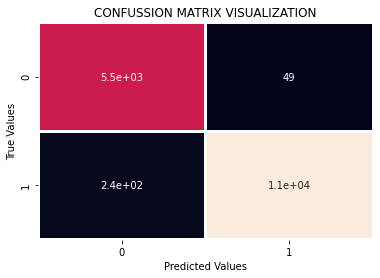

In [ ]:
# plot confusion matrix 
print(confusion_matrix(y_test,y_pred,labels=[1,0]))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,lw =2,cbar=False)
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("CONFUSSION MATRIX VISUALIZATION")
plt.show()